In [2]:
import numpy as np, pandas as pd, seaborn as sns

**ANSWERS**

**QUESTION 1(a):**

After exploring the data, it can be concluded that an AOV of 3145.13 was calculated just by taking the average of all the orders. Because there are a few orders which are huge, they end up impacting the overall mean of order_amount, which is 3145.13. 

**QUESTION 1(b):**

A better metric to report would be a summary metric that is more robust to outliers, such as the median value.

**QUESTION 1(c):**

Median Order Value = 284 Dollars



**QUESTION 2(a):**

**Answer:** 54

**Query:**

SELECT COUNT(*) FROM [Shippers]

LEFT JOIN [Orders]

ON Orders.ShipperID = Shippers.ShipperID

WHERE Shippers.ShipperName = 'Speedy Express'

**QUESTION 2(b):**

**Answer:** Peacock

**Query:**

SELECT COUNT(*) AS NUM_ORDERS, Orders.EmployeeID,

Employees.LastName FROM [Orders]

LEFT JOIN [Employees]

ON Orders.EmployeeID = Employees.EmployeeID

GROUP BY Orders.EmployeeID

ORDER BY NUM_ORDERS DESC

LIMIT 1

**QUESTION 2(c):**

**Answer:** Boston Crab Meat

**Query:**

SELECT SUM(OD.Quantity) AS NUM_ORDERS, P.ProductName FROM 

[Customers] AS C

LEFT JOIN Orders AS O 

ON O.CustomerID = C.CustomerID

LEFT JOIN OrderDetails AS OD

ON OD.OrderID = O.OrderID

LEFT JOIN Products as P

ON P.ProductID = OD.ProductID

WHERE C.Country = 'Germany'

GROUP BY ProductName

ORDER BY NUM_ORDERS DESC 

LIMIT 1

**QUESTION 1 ANALYSIS**

In [3]:
df = pd.read_csv('Downloads/2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv')

**INSPECT DATA FOR INTEGRITY & QUALITY**

In [4]:
#JUST VIEW THE DATA TO GET A GENERAL IDEA OF THE DATASET
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [5]:
# CHECK FOR MISSING VALUES 
df.isna().sum()

order_id          0
shop_id           0
user_id           0
order_amount      0
total_items       0
payment_method    0
created_at        0
dtype: int64

- There are no missing values at all. 
- Our goal is to figure out the reason why the AOV is calculated to be ~3000 dollars, so let's explore the column statistics to see what is going on

In [6]:
# CHECK SUMMARY STATISTICS
df.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


- The AOV value mentioned in the question is basically just the average of all the orders
- Mean of order_amount differs quite a lot from its median, which suggests that there are some outliers or some skewness. 
- The standard deviation of order_amount is also very high, again suggesting outliers.
- The range of order_amount & total_items is huge, needs to be inspected further

Plotting the distribution of order_amount will be helpful here to see what is going on

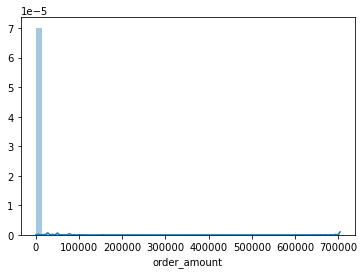

In [7]:
sns.distplot(df['order_amount'])

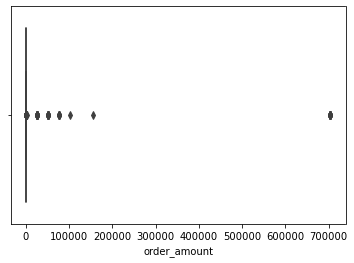

In [8]:
sns.boxplot(df['order_amount'])

We can see clearly that most of the order_amount is saturated towards the very low range, with some extreme outliers

In [9]:
df['order_amount'].quantile(0.90)

531.0

- As shown above, we can see that 90% of order_amount is less than or equal to 531. The AOV of ~3100 dollars is most likely affected by to extreme outliers

**SANITY CHECK - TIME SERIES**
- Since the data is from a 30 day window, it makes sense to check if there is some sort of relationship between time and the order value

In [10]:
df.sort_values('created_at', inplace=True)
df['timeIndex'] = [x for x in range(len(df))]

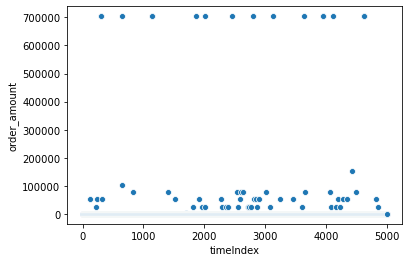

In [11]:
sns.scatterplot(x='timeIndex', y='order_amount', data=df)

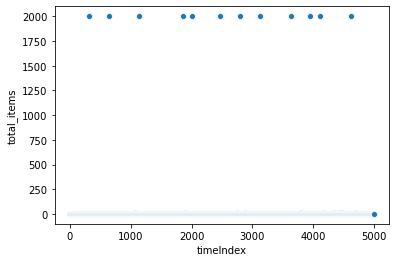

In [12]:
sns.scatterplot(x='timeIndex', y='total_items', data=df)

There doesn't seem to be any significant time-based relationship here

**SANITY CHECK - STORE LEVEL INFORMATION**

In [14]:
df.groupby('shop_id')['order_amount'].agg('mean').sort_values(ascending=False)

shop_id
42     235101.490196
78      49213.043478
50        403.545455
90        403.224490
38        390.857143
           ...      
53        214.117647
100       213.675000
32        189.976190
2         174.327273
92        162.857143
Name: order_amount, Length: 100, dtype: float64

- We can see that store 42 & 78 have very high order_amount averages, suggesting that they sell their sneakers at a premium price and perhaps orders from their store affect the AOV heavily

Overall it makes sense to use the overall median order_amount without removing any outliers. I choose not to remove outliers because the outliers are still valid data points, so by including them in the median calculation, the median is affected a little by them rather than an effect that is as great as the mean or no effect at all